## Introduction (to risk-neutral pricing)

This project involves the valuation of a European call option

$$C_t = C(S_0, t) = e^{-r(T-t)}\mathbb{E}^Q\left[\max (S_T - K, 0) \right], \quad 0\leq t \leq T$$

whose value is determined by the following:

+ $S_0$: spot price of the underlying asset
+ $\sigma$: volatility of the underlying asset
+ $r$: risk-free interest rate
+ $K$: strike price of the option
+ $T$: time to maturity

$S_t$ is the price of the underlying asset at time $t$ and $\mathcal{Q}$ is the risk-neutral measure.
We assume that the underlying asset does not pay dividends.

### Option Pricing Models

#### 1. Black-Scholes model

The stock price dynamics is given by:

$$S_t = S_0 \exp\left(\left(r - \frac{1}{2}\sigma^2\right)t + \sigma W_t\right)$$

where $W_t$ is a $\mathbb{Q}$-Brownian motion. The closed-form solution under the Black-Scholes model is given by:

$$C_0 = S_0 N(d_1) - K e^{-rT} N(d_2)$$

where $N$ is the CDF of the standard normal distribution. The $d_1$ and $d_2$ terms are defined as:
$$d_1 = \frac{\log(S_0/K) + (r + \sigma^2/2)T}{\sigma \sqrt{T}}, \quad d_2 = d_1 - \sigma \sqrt{T}$$



In [74]:
import numpy as np
import matplotlib.pyplot as plt

class GBM:
    """
    Initialises the GBM model

    Parameters
    ----------
    S0 : float
        Initial stock price
    r : float
        Risk-free interest rate
    sigma : float
        Volatility of the stock price process
    T : float
        Time horizon
    N : int
        Number of subintervals for sample path
    """
    def __init__(self, S0, r, sigma, T, N):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.T = T
        self.N = N
    
    def phi(self, t, u):
        """
        Evaluates the characteristic function of log(St), where St is the
        stock price given by a Geometric Brownian motion

        Parameters
        ----------
        t : array_like(float, ndim=1)
            Time of log-stock price for charateristic function to be computed;
            usually the maturity of the call option

        u : array_like(float, ndim=1)
            Value at which the characteristic function of log(St) is to be
            computed

        Returns
        -------
        phi_t(u) : array_like(float, ndim=1)
            Value of characteristic function of log(St) computed at u.
        """
        S0, r, sigma = self.S0, self.r, self.sigma
        mu = np.log(S0) + (r - 0.5*sigma**2)*t
        var = t*sigma**2
        return np.exp(1j*u*mu  - 0.5*u**2*var)
    

    def sample_path(self, plot=False):
        """
        Generates sample path of the GBM model and returns terminal price

        Parameters
        ----------
        plot : bool, optional
            If true, plots and displays the generated sample path

        Returns
        -------
        ST : float
            The simulated value of the terminal stock price at time T
        """
        dt = self.T / self.N
        t = np.linspace(0, self.T, self.N + 1)
        dW = np.random.normal(0, np.sqrt(dt), self.N)
        W = np.insert(np.cumsum(dW), 0, 0)

        S0, r, sigma = self.S0, self.r, self.sigma
        S_sim = S0 * np.exp((r - 0.5*sigma**2)*t + sigma*W)

        if plot:
            plt.plot(t, S_sim)
            plt.xlabel('Time $(t)$')
            plt.ylabel('Stock Price $(S_t)$')
            plt.title('Sample path of GBM ($S_0 = {}, r = {}, \sigma = {}$)'.format(S0, r, sigma))
            plt.show()
        return S_sim[-1]

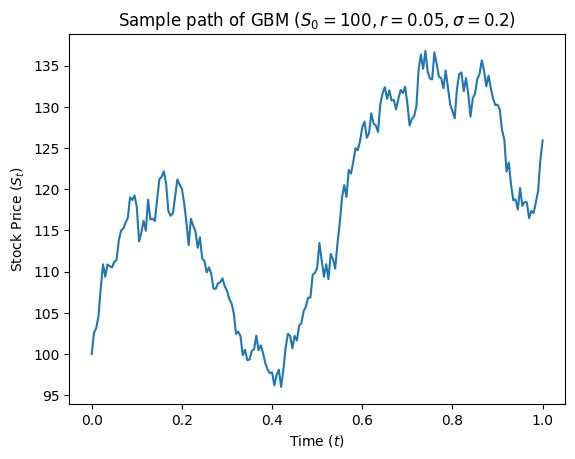

125.93115241587958

In [76]:
# Set the seed for reproducibility
np.random.seed(0)

# Set strike price
K = 140

# Set parameters for the GBM model
S0, r, sigma, T, N = 100, 0.05, 0.2, 1, 200

# Create an instance of the GBM model
S = GBM(S0, r, sigma, T, N)

# Show sample path of the GBM model
S.sample_path(plot=True)

### 2. Variance Gamma model

The stock price dynamics is given by:

$$S_t = S_0 \exp((r + \omega)t + X_t (\theta, \sigma, \nu))$$

where $X_t (\theta, \sigma, \nu)$ is a Variance Gamma process. 



In [100]:
class VarianceGamma:
    """
    Initialises the Variance-Gamma process.

    The formula for the Stock price at time t is given by:
        S_t = exp((r + ω)t + X_t(θ, σ, ν)),

    where X_t(θ, σ, ν)) is a Variance-Gamma process. 

    Parameters
    ----------
    S0 : float
        Initial stock price
    
    r : float
        Risk-free interest rate
    
    sigma : float
        Volatility parameter of VG process
    
    theta : float
        Drift parameter of VG process
    
    nu : float
        Variance rate parameter of Gamma process 
    
    omega : float, optional
        Drift correction term. Default value is
            ω = 1/ν log(1 - θν - 0.5νσ^2),
        which ensures the stock's expected return is equal to the continuously
        compounded risk free rate r.

    T : float
        Time horizon
    
    N : int
        Number of subintervals for sample path
    """
    def __init__(self, S0, r, sigma, theta, nu, T, N, omega=None):
        self.S0 = S0
        self.r = r
        self.sigma = sigma
        self.theta = theta
        self.nu = nu
        self.T = T
        self.N = N

        if omega is None:
            omega = (1/nu) * np.log(1 - theta*nu - 0.5*nu*sigma**2)
        self.omega = omega
    
   
    def phi(self, t, u):
        """
        Evaluates the characteristic function of log(St), where St is the
        stock price given by a Variance-Gamma process.

        Parameters
        ----------
        t : array_like(float, ndim=1)
            Time of log-stock price for charateristic function to be computed;
            usually the maturity of the call option.

        u : array_like(float, ndim=1)
            Value at which the characteristic function of log(St) is to be
            computed.

        Returns
        -------
        phi_t(u) : array_like(float, ndim=1)
            Value of characteristic function of log(St) computed at u. 
        """
        S0, theta, sigma, nu = self.S0, self.theta, self.sigma, self.nu
        r, omega = self.r, self.omega
        denom = np.power((1 - 1j*theta*nu*u + 0.5*(u*sigma)**2*nu), t/nu)
        return np.exp(1j*u*(np.log(S0) + (r + omega)*t)) / denom
    

    def sample_path(self, plot=False):
        """
        Generate a sample path of stock based on the Variance-Gamma process
        and return the terminal stock price.

        Parameters
        ----------
        plot : bool, optional
            If true, plots and displays the generated sample path.

        Returns
        -------
        ST : float
            The simulated value of the terminal stock price at time T.
        """
        S0, theta, sigma, nu = self.S0, self.theta, self.sigma, self.nu
        r, omega = self.r, self.omega

        dt = self.T/self.N
        t = np.linspace(0, self.T, self.N + 1)
        Z = np.random.normal(0, 1, self.N)

        # Generate gamma increments and evaluate at Arithmetic Brownian
        # https://en.wikipedia.org/wiki/Variance_gamma_process#Simulation
        dG = np.random.gamma(dt/nu, nu, N)
        X = theta*np.cumsum(dG) + sigma*np.cumsum(np.sqrt(dG)*Z)
        X = np.insert(X, 0, 0)    # Set X_0 = 0
        S_sim = S0 * np.exp((r + omega)*t + X)

        if plot:
            plt.plot(t, S_sim)
            plt.xlabel('Time $(t)$')
            plt.ylabel('Stock Price $(S_t)$')
            plt.title(r'Sample path of VG ($S_0 = {}, r = {}, \sigma = {}, \theta = {}, \nu = {}$)'.format(S0, r, sigma, theta, nu))
            plt.show()

        return S_sim[-1]

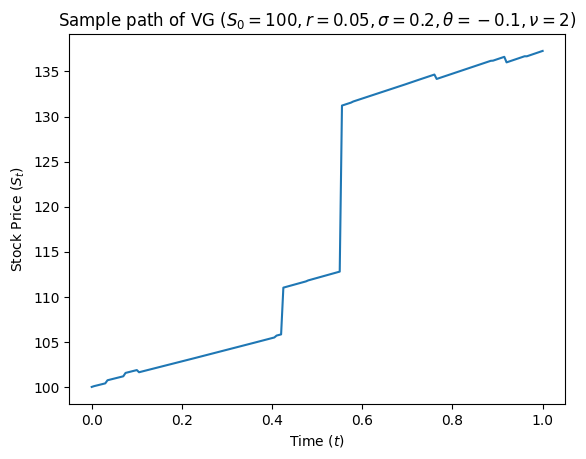

137.27996256561465

In [101]:
# Set the seed for reproducibility
np.random.seed(0)

# Set parameters for the VG model
K = 140
S0, r, sigma, T, N = 100, 0.05, 0.2, 1, 200
theta, nu = -0.1, 2

T, N = 1, 200

# Create an instance of the VG model
V = VarianceGamma(S0, r, sigma, theta, nu, T, 200)

# Show sample path of the VG model
V.sample_path(plot=True)

In [ ]:
from scipy.fft import fft
from scipy.integrate import quad
from scipy.stats import gamma
from scipy.stats import norm